<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_projects/blob/main/Image_classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h2>Projet:</h2>**
Create a model for handwritten recognition.

**<h2>Model:</h2>**
Traditional CNN.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cd97d78d-e35b-f00f-6120-e3d2eb5268a3)


## Discover and visualize the datas

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(train_data, test_data), info = tfds.load("mnist", 
                     split=["train", "test"],
                     shuffle_files=True,
                     as_supervised=True, 
                     with_info=True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [5]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
class_names = info.features["label"].names
class_names[:10], len(class_names)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10)

In [7]:
def montre_une_image(dataset):
  """
  Pick a random image from prefetch Dataset, give various info on the image and plot it.

  Parameter
  ---------
  dataset: PrefetchDataset.

  Returns
  -------
  Image shape
  Image type
  Label number
  Label name
  Image plot
  """
  
  data = dataset.shuffle(int(len(dataset)/100))
  sample = data.take(1)

  for image, label in sample:
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")
    print(f"Label num: {label}")
    print(f"Label str: {class_names[label]}")

  image = tf.squeeze(image)
  plt.imshow(image)
  plt.axis(False)

Image shape: (28, 28, 1)
Image dtype: <dtype: 'uint8'>
Label num: 6
Label str: 6


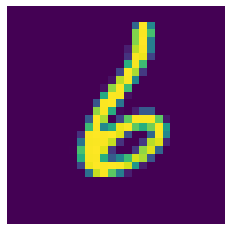

In [8]:
montre_une_image(train_data)

## Data preprocessing

In [9]:
sample = train_data.take(1)

In [10]:
for image, label in sample:
  print(f"Image shape: {image.shape}")
  print(f"Image dtype: {image.dtype}")
  print(f"Label num: {label}")
  print(f"Label str: {class_names[label]}")

Image shape: (28, 28, 1)
Image dtype: <dtype: 'uint8'>
Label num: 4
Label str: 4


In [11]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [12]:
def preprocessing_images(image, label, img_size=28):
  """
  Converts images datatypes from uint8 to float32, reshape them to [img_shape, img_shape, 3] and normalize them [0,1].

  Parameters
  ----------
  Image: numpy array, dtype=uint8
  Label: int64
  img_size: int64

  Returns
  -------
  Tuple (image, label)
  """
  image = tf.image.resize(image, [img_size, img_size])
  image = image / 255
  return tf.cast(image, tf.float32), label

In [13]:
train_data = train_data.map(map_func=preprocessing_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocessing_images, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create Model: Conv 2D

### Model Conv2D with kernel_size=3

In [16]:
# Create the model
from tensorflow.keras import layers

inputs = layers.Input(shape=(28, 28, 1), dtype="float32")
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(len(class_names), activation="softmax")(x)

model_1 = tf.keras.Model(inputs, output, name="CNN_kernel_3")

In [17]:
# Compile
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

In [18]:
model_1.summary()

Model: "CNN_kernel_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 16)        2320      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)       

In [19]:
# Fit the model
history_model_1 = model_1.fit(train_data,
            epochs=15,
            validation_data=test_data,
            verbose=1,
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            verbose=1,
                                                            patience=2),
                       tf.keras.callbacks.ModelCheckpoint("checkpoint",
                                                          monitor="val_accuracy",
                                                          save_best_only=True)])

Epoch 1/15
1875/1875 [==============================] - 30s 10ms/step - loss: 0.4188 - accuracy: 0.8618 - val_loss: 0.1414 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1202 - accuracy: 0.9631 - val_loss: 0.0692 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 3/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0898 - accuracy: 0.9728 - val_loss: 0.0690 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 4/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0754 - accuracy: 0.9774 - val_loss: 0.0564 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 5/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0650 - accuracy: 0.9801 - val_loss: 0.0543 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 6/15
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0588 - accuracy: 0.9823 - val_loss: 0.0622 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 7/15
1875/1875 [===========================

In [41]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Parameter
  ---------
  history: tf.keras.callbacks.History

  Returns
  -------
  Plot for loss and accuracy.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure(figsize=(7,4))
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=(7,4))
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [ ]:
plot_loss_curves(history_model_1)

### Conv2D with multi kernel_size

In [20]:
# Create model 2

inputs = layers.Input(shape=(28, 28, 1), dtype="float32")
x = layers.Conv2D(filters=16, kernel_size=7, activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=7, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=16, kernel_size=5, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=16, kernel_size=5, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(len(class_names), activation="softmax")(x)

model_2 = tf.keras.Model(inputs, output, name="CNN_kernel_muti")

In [21]:
# Compile
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

In [22]:
model_2.summary()

Model: "CNN_kernel_muti"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 16)        800       
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 16)        12560     
                                                                 
 conv2d_12 (Conv2D)          (None, 22, 22, 16)        6416      
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 18, 16)        6416      
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 16)    

In [23]:
# Fit the model
history_model_2 = model_2.fit(train_data,
                              epochs=15,
                              validation_data=test_data,
                              verbose=1,
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", verbose=1, patience=2),
                                         tf.keras.callbacks.ModelCheckpoint("checkpooint",
                                                                            monitor="val_accuracy",
                                                                            save_best_only=True)])

Epoch 1/15
1875/1875 [==============================] - 22s 11ms/step - loss: 0.3927 - accuracy: 0.8747 - val_loss: 0.1588 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/15
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1386 - accuracy: 0.9594 - val_loss: 0.0912 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 3/15
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1073 - accuracy: 0.9689 - val_loss: 0.0800 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 4/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0905 - accuracy: 0.9743 - val_loss: 0.0580 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 5/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0767 - accuracy: 0.9783 - val_loss: 0.0734 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 6/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9802
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1875/1875 [======================

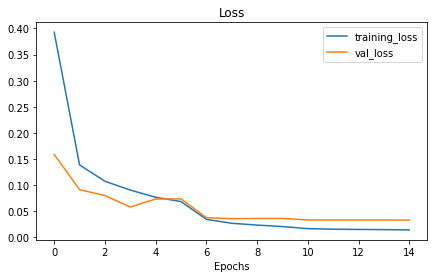

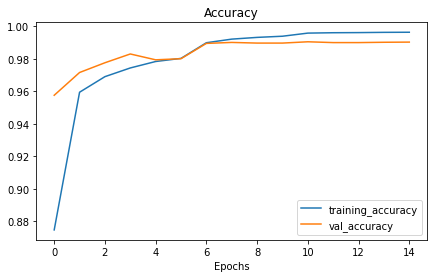

In [40]:
plot_loss_curves(history_model_2)

## Model comparison

In [44]:
import pandas as pd

df_1 = pd.DataFrame(history_model_1.history)
df_2 = pd.DataFrame(history_model_2.history)

In [58]:
df_1['val_accuracy'].max(), df_2["val_accuracy"].max()

(0.9922999739646912, 0.9904000163078308)

In [59]:
df_1["val_loss"].min(), df_2["val_loss"].min()

(0.02579556219279766, 0.032956670969724655)